### 🖋️ Phishing Detection in Email Bodies

In this notebook, we will build a **classification model** for the **Phishing detection on the email body** task.  
The goal is to predict the phishing of a given email body.  

The dataset that we are using will be loaded from google drive and which was previously processed in the previous notebook.


---

### ⚙️ Installing Helper Packages

In the following code cell, we will install the packages `helperfns`, `kaggle`, and `pigmenta`.  
These libraries provide useful utilities for machine learning workflows, including data preprocessing, visualization, and experiment management.

**References:**

1. [helperfns on PyPI](https://pypi.org/project/helperfns/)  
2. [pigmenta on PyPI](https://pypi.org/project/pigmenta/)


In [1]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 14.2 MB/s eta 0:00:00


### 📦 Imports

In the following code cell, we will import all the necessary packages that will be used throughout this notebook.  
These include libraries for data handling, visualization, and model development.


In [2]:

import torch
import random
import warnings
import seaborn as sns
import os
import json
import re
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, regexp_replace, length, avg, explode, col, size
from pyspark.ml.feature import Tokenizer
from pyspark.sql import functions as Fn

from collections import Counter, defaultdict
from helperfns.tables import tabulate_data
from pigmenta import PALETTES
from helperfns.visualization import plot_wordcloud, plot_classification_report, plot_complicated_confusion_matrix
from helperfns.utils import hms_string
from torch import nn
from sklearn.utils import resample
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from google.colab import drive

warnings.filterwarnings('ignore')

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


torch:  2.8.0+cu126
numpy:  2.0.2
pandas:  2.2.2


### Mounting Google Drive
In the following code cell we are going to mount the google drive where our pretrained word vectors will be loaded from and the previously dataset were loaded.

In [3]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


### 🎲 Setting Seeds

In the following code cell, we will set a fixed seed value for all random operations to ensure **reproducibility** of the results.  
This helps guarantee that the model produces consistent outputs every time the notebook is run.


In [4]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### 🖥️ Device

In the following code cell, we will check for the availability of a **GPU** device and use it if possible.  
Utilizing a GPU can significantly accelerate model training and computations `(Khairy et al., 2020)`.


### Refs:

1. Khairy, M., Shen, Z., Aamodt, T.M. and Rogers, T.G., 2020, May. Accel-sim: An extensible simulation framework for validated gpu modeling. In 2020 ACM/IEEE 47th Annual International Symposium on Computer Architecture (ISCA) (pp. 473-486). IEEE.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 📂 Dataset

Next, we will read our data from text files into a **Pandas DataFrame** using the `read_csv` method.  
We will load only the `clean_phishing_email.csv` file, as it contains the email body samples along with their corresponding **labels**.

**Objective:** Accurately identify the phishing emails based on the email body.


In [6]:
dataframe = pd.read_csv("/content/MyDrive/MyDrive/NLP Data/zim/clean_phishing_email.csv")
dataframe.head(2)

,body,label
0,buck up your troubles caused by small dimensio...,phishing
1,upgrade your sex and pleasures with these tech...,phishing


In the following code cell, we will **check the size of the dataset**.


In [7]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 98,260


In the following code cell we are going to remove `nan` values from the dataset if there are any.

In [8]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()
dataframe.head(2)

,body,label
0,buck up your troubles caused by small dimensio...,phishing
1,upgrade your sex and pleasures with these tech...,phishing


In the following code cell, we are going to define a threshold value and filter out all text entries that contain fewer words than this threshold. We want to make sure that short emails are removed.

In [9]:
threshold = 100
dataframe = dataframe[dataframe['body'].apply(lambda x: len(str(x).split()) >= threshold)].reset_index(drop=True)
dataframe.head(2)

,body,label
0,the daily top from cnn com top videos and stor...,phishing
1,would anyone object to removing so from this l...,legitimate


Next, we are going to inspect a few examples from the dataset after removing all rows containing text with fewer words than the defined threshold.


In [10]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 51,487


In this section, we will **visualize the dataset** using charts.  
First, we will examine the **distribution of labels** with a bar chart to understand how the text samples are distributed across different labels.


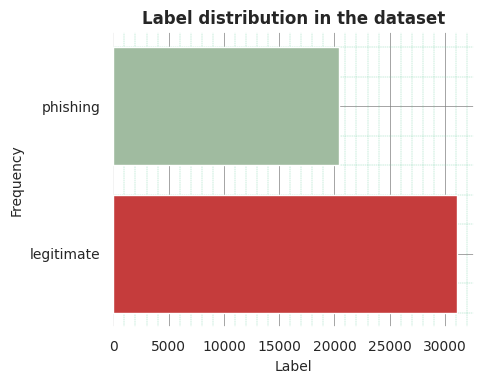

In [11]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(5, 4))
sns.countplot(data=dataframe, y="label", palette=PALETTES.christmas,
              legend=False,  fill=True)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(f"Label distribution in the dataset", fontsize=12, weight="bold")
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

### ⚖️ Handling Class Imbalance

The dataset is **not balanced**, meaning some labels classes have significantly more examples than others.  
To ensure that **accuracy** remains a reliable performance metric, we will **downsample the majority classes** so that each labels class has approximately the same number of samples as the minority class `(Ngwenya and Garidzira, 2025)`.  

This approach helps prevent the model from becoming biased toward the majority classes and allows for a more fair evaluation of model performance.

> Ngwenya, S. and Garidzira, T.C., 2025. Enhanced Fake News Detection with Domain-Specific Word Embeddings: A TorchText-Based Method for News Semantics Representation. The Indonesian Journal of Computer Science, 14(4).


In [12]:
new_dataframe = dataframe.copy()

min_class_count = new_dataframe['label'].value_counts().min()
downsampled_list = []
for label in new_dataframe['label'].unique():
    class_df = new_dataframe[new_dataframe['label'] == label]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

### 🍰 Visualizing the Balanced Dataset

In the following code cell, we are going to **visualize the distribution** of the balanced dataset using a **pie chart**.  
This visualization helps us confirm that all label classes now have approximately equal representation after the downsampling process.


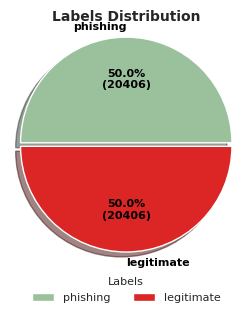

In [13]:
samples = dict(balanced_df.label.value_counts())

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.christmas,
    explode=[.01 for _ in range(len(samples))]
)
plt.axis('equal')
plt.title("Labels Distribution", fontsize=10, weight="bold")
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Labels", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In the following code cell, we will **split the dataset into training, validation and testing sets**.  
The testing set will also be used for **model evaluation** during training and **validation** to assess performance.


In [14]:
train, test = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=SEED)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

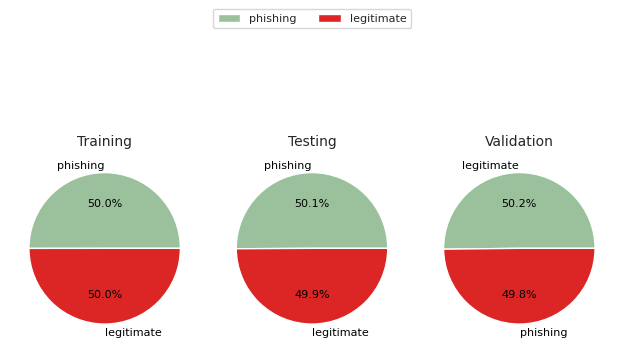

In [15]:
train_dist_label	= {i:0 for i in train.label.unique()}
for val in train.label:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test.label.unique()}
for val in test.label:
  test_dist_label[val] += 1

valid_dist_label	= {i:0 for i in valid.label.unique()}
for val in valid.label:
  valid_dist_label[val] += 1

fig, axes = plt.subplots(1, 3)

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.christmas
            )
axes[0].set_title("Training", fontsize=10)

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.christmas
            )
axes[1].set_title("Testing", fontsize=10)

axes[2].pie(valid_dist_label.values(), labels=valid_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.christmas)
axes[2].set_title("Validation", fontsize=10)

fig.legend(train.label.value_counts().index, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

We are going to skip the processes of cleaning text becuase we have already done that in the data processing notebook. Cleaning text is an important step ensures that the text is standardized and ready for feature extraction or modeling.


In the following code cell we are going to extract features and labels for the `training`, `testing` and `validation` subsets.

In [16]:
train_texts = train.body.values
train_labels = train.label.values

test_texts = test.body.values
test_labels = test.label.values

valid_texts = valid.body.values
valid_labels = valid.label.values

Next, we will create a **Counter object** to store the word counts from the dataset.  
These counts will be used to **build our custom vocabulary** for subsequent analysis or modeling.


In [17]:
test_counter = Counter()
valid_counter = Counter()
train_counter = Counter()

for line in train_texts:
    train_counter.update(line.lower().split())

for line in test_texts:
    test_counter.update(line.lower().split())

for line in valid_texts:
    valid_counter.update(line.lower().split())

Next, we will **visualize the most common words** in the cleaned dataset using **word clouds**.  

This provides an intuitive way to see the most frequently occurring words and gain insights into the different people's email body writing styles.


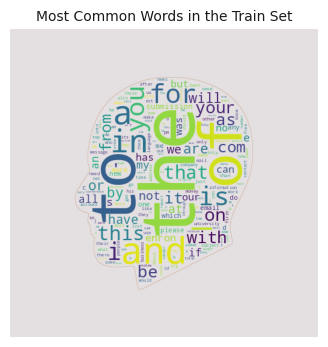

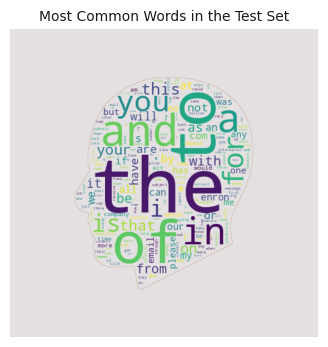

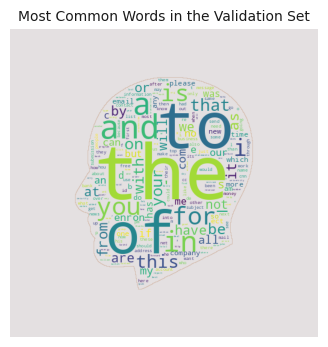

In [18]:
plot_wordcloud(
    train_counter, title="Most Common Words in the Train Set", mask="head", figsize=(4, 4),
    fontsize=10
)
plot_wordcloud(
    test_counter, title="Most Common Words in the Test Set", mask="head", figsize=(4, 4),
    fontsize=10
)

plot_wordcloud(
    valid_counter, title="Most Common Words in the Validation Set", mask="head", figsize=(4, 4),
    fontsize=10
)

### 🔖 Label Pipeline

Currently, our labels are in **text format**.  
To use them in machine learning models, we need to **convert these labels into numerical values**.  

The process is straightforward:  
1. Extract all **unique labels** from the dataset.  
2. Create a `labels_vocab` mapping that represents each label as an **integer**.  

This mapping allows the model to work with numerical labels while preserving the correspondence to the original labels.


In [19]:
labels_dict = {k: v for v, k in enumerate(train.label.unique())}
labels_dict

{'phishing': 0, 'legitimate': 1}

The `label_pipeline` function takes a **text label** as input and returns its corresponding **integer representation**.  
This allows us to consistently convert all labels into numeric form for model training.


In [20]:
label_pipeline = lambda x: labels_dict[x]

### 📖 Vocabulary

Next, we will create a **Vocabulary class** and initialize it using the `counter` object.  

- We will set `min_freq = 5`, meaning any word that appears **less than 5 times** will be treated as an **unknown token**.  
- We will also specify **special tokens** (such as `<PAD>`, `<UNK>`, etc.) during the creation of the vocabulary object.  

This ensures that our vocabulary captures meaningful words while handling rare or unseen words appropriately.


In [21]:
class vocab:
    def __init__(self, counter, min_freq=1, specials=('[unk]', '[pad]', '[sos]', '[eos]')):
        self.freqs = counter
        self.itos = list(specials)
        self.stoi = {}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = defaultdict(lambda: self.itos.index('[unk]'))  # default to unk
        for idx, token in enumerate(self.itos):
            self.stoi[token] = idx

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi[token]

    def get_stoi(self):
        return self.stoi
    def get_itos(self):
        return self.itos

vocabulary = vocab(train_counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### 🔢 STOI - `String To Integer`

We will create a **dictionary mapping each word to a unique integer**, which will serve as our **actual vocabulary**.  

In the following code cell, we will initialize an object called `stoi` — a **word-to-index mapping**.  
This dictionary will be used both during **model training** and **inference** to convert words into numerical representations.


In [22]:
stoi = vocabulary.get_stoi()

### 📝 Text Pipeline

After tokenizing the text, we need a way to **convert words into numbers**, since machine learning models can only process numerical inputs.  

This is where the `text_pipeline` function comes in. The function:

1. Takes a **sentence** as input.  
2. Tokenizes the sentence into words.  
3. Converts each word into its corresponding **integer index** from the `stoi` vocabulary.  

**Note:** Any word not found in the vocabulary (`stoi`) will be mapped to the **unknown token** (`'[UNK]'`) with index `0`.


In [23]:
def text_pipeline(x: str):
  values = list()
  tokens = x.lower().split(" ")
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### 📊 Data

In addition to the labeled email body and labels, we will use **pre-trained GloVe word embeddings** to convert words into dense semantic vectors. These embeddings help capture global word co-occurrence statistics, which can improve performance in text classification and stylometry tasks.

### 🔍 How GloVe Will Be Used

- We'll download pre-trained GloVe embeddings (e.g. 100-dim or 300-dim vectors).
- Use them to convert each word in our dataset into its embedding vector.
- Possibly average (or apply more advanced aggregation) the word vectors to represent each text snippet.
- Use these embedded text vectors for exploratory data analysis (comparing email body by vector similarity, clustering), before any classification modeling.





### 🌐 Pretrained Vectors

In the following code cell, we will download **pretrained word vectors** using `GloVe.6B.300d`.  

- These vectors were trained on approximately **6 billion words**.  
- Each word is represented as a **300-dimensional vector**, capturing semantic relationships between words.  
- Using these pretrained embeddings allows us to leverage prior knowledge of word semantics, which can improve model performance.


In [24]:
embedding_path = "/content/MyDrive/MyDrive/NLP Data/glove.6B/glove.6B.300d.txt"
EMBEDDING_DIM = 300
glove_vectors = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    glove_vectors[word] = vectors

### 🧩 Creating Embedding Matrix

Now that we have the GloVe vectors, we need to **customize them** to fit our use case.  

We will create an **embedding matrix** that aligns with our vocabulary.  
Essentially, this matrix provides a **word-to-vector mapping** for all the words in our vocabulary, allowing the model to convert each word index into its corresponding vector representation during training and inference.


In [25]:
VOCAB_SIZE = len(stoi)

EMBEDDING_MATRIX = torch.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, index in stoi.items():
    vector = glove_vectors.get(word)
    try:
        if vector is not None:
            if isinstance(vector, torch.Tensor):
                EMBEDDING_MATRIX[index] = vector
            else:
                EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
        else:
            EMBEDDING_MATRIX[index] = torch.zeros(EMBEDDING_DIM)
    except (IndexError, Exception):
        continue

In [26]:
assert VOCAB_SIZE == EMBEDDING_MATRIX.size(0), "They should be the same"

In the following code cell, we will **inspect the embedding matrix** by checking the vector representation for the word `"the"`.  
This helps verify that our embeddings have been correctly mapped to the vocabulary.


In [27]:
EMBEDDING_MATRIX[stoi['the']]

tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8

### 📂 Creating Dataset for Training

In the following code cell, we will create a **dataset class** called `PhishingDataset`.  
This class takes in the **email body** and their corresponding **labels**, allowing us to efficiently load and preprocess data for model training.


In [28]:
class PhishingDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(PhishingDataset, self).__init__()
    self.text = text
    self.labels = labels

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.text)

### 🔄 `collate_fn`

We will create a **collate function** called `tokenize_batch`.  
This function takes a batch of data and performs **preprocessing on the text**, and it will be passed to the `DataLoader` to handle batch preparation efficiently.


### `tokenize_batch` Function Details

- The function takes in a **batch of samples** and converts the text features into their **integer representations**.  
- It **pads** or **truncates** sequences to a uniform length so that all inputs in a batch have the same size.  
- The function returns the processed **features**, ready for model input.


In [29]:
def tokenize_batch(batch, max_len=300, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  features = torch.cat(text_list, dim=0)
  return torch.FloatTensor(labels_list) if len(set(labels_list)) == 2 else torch.LongTensor(labels_list), features

### 📂 Datasets

In the following code cell, we will create the **datasets** for all three sets using the `PhishingDataset` class.  
This organizes the data for **training, validation, and testing**, ensuring each set is properly prepared for model input.


In [30]:
train_dataset = PhishingDataset(train_labels, train_texts)
test_dataset = PhishingDataset(test_labels, test_texts)
valid_dataset = PhishingDataset(valid_labels, valid_texts)

### 🔁 Iterators

In the following code cell, we will create **data loaders** using the `DataLoader` class from `torch.utils.data`.  
These loaders will handle **batching, shuffling, and preprocessing** of the datasets during training and evaluation.


In [31]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

### ✅ Checking a Single Batch

In this step, we will inspect a **single batch of data** from the DataLoader.  
This allows us to verify that the **features and labels** are correctly processed and ready for model training.


In [32]:
lbl, txt = next(iter(train_loader))

Checking a single batch of labels.

In [33]:
lbl

tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 

The first sentence in the batch.

In [34]:
txt[0]

tensor([1810, 1603, 2779, 2780, 2779, 2777, 1847, 2781, 2419, 2782, 1609, 1351,
        2783, 2784, 2785,  469, 2786, 2787, 2288, 2788, 2789, 2790,  233, 2791,
        1078, 2792,  428,  724, 2636,  242, 2467,  124,  154, 2793,  585,  617,
         585, 2794, 2792,  428,  617,  585, 2794, 2792,  428,  617,  585, 2794,
        2792,  428, 1078, 2792,  428,  724, 2636,  242, 2467,  124,  154, 2793,
         585,  617,  585, 2794, 2792,  428,  617,  585, 2794, 2792,  428,  617,
         585, 2794, 2792,  428, 1078, 2792,  428,  724, 2636,  242, 2467,  124,
         154, 2793,  585,  617,  585, 2794, 2792,  428,  617,  585, 2794, 2792,
         428, 1078, 2792,  428,  724, 2636,  242, 2467,  124,  154, 2793,  585,
        1078, 2792,  428,  724, 2636,  242, 2467,  124,  154, 2793,  585, 1078,
        2792,  428,  724, 2636,  242, 2467,  124,  154, 2793,  585,  617,  585,
        2794, 2792,  428,  617,  585, 2794, 2792,  428,  617,  585, 2794, 2792,
         428,  617,  585, 2794, 2792,  4

### 🧠 PhishingBiLSTM

In the following code cell, we will **build a model using LSTM layers** for classifying email bodies.  

We use a **BiLSTM (Bidirectional LSTM)** model because it is well-suited for efficiently processing **sequential data**, as supported by previous studies (Ngwenya & Garidzira, 2025; Vambe & Garidzira, 2024; Siami-Namini et al., 2019).

**References:**

1. Ngwenya, S. & Garidzira, T.C. (2025). *Enhanced Fake News Detection with Domain-Specific Word Embeddings: A TorchText-Based Method for News Semantics Representation.* The Indonesian Journal of Computer Science, 14(4).  
2. Vambe, W.T. & Garidzira, T.C. (2024, November). *A Comparative Analysis of Convolutional Neural Networks, Bi-Directional Gated Recurrent Units, and Bi-Directional Long Short-Term Memory for Sequential Data Processing Using Human Emotions Dataset.* In 2024 4th International Multidisciplinary Information Technology and Engineering Conference (IMITEC) (pp. 01-08). IEEE.  
3. Siami-Namini, S., Tavakoli, N., & Namin, A.S. (2019, December). *The Performance of LSTM and BiLSTM in Forecasting Time Series.* In 2019 IEEE International Conference on Big Data (Big Data) (pp. 3285-3292). IEEE.


In [35]:
class PhishingBiLSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_size,
        hidden_size,
        output_size,
        num_layers=2,
        bidirectional=True,
        dropout=0.5,
        pad_index=0,
        embedding_matrix=None
    ):
        super(PhishingBiLSTM, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            padding_idx=pad_index
        )

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2 if bidirectional else hidden_size)
        self.out = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        if self.bidirectional:
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            hidden = hidden[-1]

        hidden = self.layer_norm(hidden)
        hidden = self.dropout(hidden)
        return self.out(hidden)

### PhishingCNN

In the following code cell, we will define the **`PhishingCNN`** model, which utilizes **`Conv1D`** layers for text feature extraction. Convolutional Neural Networks (CNNs) are well-established for their effectiveness in text classification tasks, as demonstrated by *Matobobo and Garidzira (2025)*.

> *Matobobo, C. and Garidzira, T.C., 2025. Examining 1D and 2D CNN Architectures in Comparison for Sentiment Analysis in Sequential Data: A Case Study of Spotify Music Reviews. The Indonesian Journal of Computer Science, 14(2).*


In [36]:
class PhishingCNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
            dropout, pad_idx):
    super(PhishingCNN, self).__init__()
    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    )
    self.convs = nn.Sequential(
        nn.ModuleList([
            nn.Conv1d(
                in_channels = embedding_dim,
                out_channels = n_filters,
                kernel_size = fs
              ) for fs in filter_sizes
        ])
    )
    self.out = nn.Sequential(
        nn.Linear(len(filter_sizes) * n_filters, output_dim)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, lenght=None):
    embedded = self.embedding(text)
    embedded = embedded.permute(0, 2, 1)
    conved = [F.relu(conv(embedded)) for conv in self.convs[0]]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.out(cat)

Next, we will create an **instance of the `PhishingBiLSTM` and `PhishingCNN` models**.  


This initializes the network with the specified architecture, ready for training on our dataset.


In [37]:
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
phishing_bilstm = PhishingBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
phishing_bilstm

PhishingBiLSTM(
  (embedding): Embedding(189954, 300, padding_idx=1)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [38]:
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
phishing_cnn = PhishingCNN(
 INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX
).to(device)
phishing_cnn

PhishingCNN(
  (embedding): Sequential(
    (0): Embedding(189954, 300, padding_idx=1)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
      (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
      (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=300, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### ⚙️ Model Parameters

In the following code cell, we will **count the number of parameters** in our `PhishingBiLSTM` and  `PhishingBiLSTM` model.  
This helps us understand the **model's complexity** and the number of learnable weights.


In [39]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["BiLSTM", *count_trainable_params(phishing_bilstm)],
    ["CNN", *count_trainable_params(phishing_cnn)]
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| BiLSTM |   57,822,553 |       57,822,553 |
| CNN    |   57,346,801 |       57,346,801 |
+--------+--------------+------------------+


### 🌐 Loading Embedding Vectors

In the following code cells, we will **load the pretrained custom vectors** into the embedding layer of our model.  
We will assign the vectors that correspond to our vocabulary using:

```python
model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)
```

> This ensures that the model starts with meaningful word representations based on GloVe embeddings.

In [40]:
assert EMBEDDING_MATRIX.size(0) == VOCAB_SIZE, "This must match!"

In [41]:
phishing_bilstm.embedding.weight.data.copy_(EMBEDDING_MATRIX)
phishing_cnn.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

### ⚡ Optimizer and Criterion

We will use the **Adam optimizer** for training the model.  

For the loss function, we will use **`BCEWithLogitsLoss()`**, as this is a **binary classification** problem where each email body sample belongs to one of several labels.


In [42]:
optimizers = {
   "bilstm": torch.optim.Adam(
        phishing_bilstm.parameters(),
        lr=1e-3,
        weight_decay=1e-5,
        betas=(0.9, 0.999),
        eps=1e-8
    ),
    "cnn": torch.optim.Adam(
        phishing_cnn.parameters(),
        lr=1e-3,
        weight_decay=1e-5,
        betas=(0.9, 0.999),
        eps=1e-8
    )
}

criterions = {
    "bilstm": nn.BCEWithLogitsLoss().to(device),
    "cnn": nn.BCEWithLogitsLoss().to(device)
}

In the following code cell, we will create the **`binary_accuracy` function**.  
This function calculates the **binary accuracy** by comparing the predicted labels with the true labels, providing a measure of model performance for multi-class classification.


In [43]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### 🏋️ Training and Evaluation Functions

In the following code cell, we will define the **`train_fn`** and **`evaluate_fn`** functions:  

- **`train_fn`**: Handles the forward pass, loss computation, and backpropagation for model training.  
- **`evaluate_fn`**: Computes the loss and accuracy on validation or test data without updating the model weights.


In [44]:

def train_fn(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_fn(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


### 🔄 Training Loop

During model training, we will **train the model** while continuously tracking its performance.  

The following `History` class serves as a **data structure to store the training history**, including metrics such as loss and accuracy for each epoch.


In [45]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

In the following code cell, we will define the **`run_train_loop` function**.  
This function orchestrates the **entire training process**, including running the training and evaluation steps for multiple epochs and updating the training history.


In [46]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=6, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train_fn(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate_fn(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In the following code cell we are going to run the training loop for the `PhishingCNN` model.

In [47]:
EPOCHS = 10
history_cnn, elt_cnn, last_saved_epoch_cnn = run_train_loop(
    phishing_cnn, 'cnn.pt', train_loader, test_loader, EPOCHS,
    optimizer=optimizers['cnn'], criterion=criterions['cnn']
)

EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.204 |    0.921 | 0:00:18.14 |
| Validation | 0.071 |    0.976 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.053 |    0.983 | 0:00:17.38 |
| Validation | 0.043 |    0.985 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.025 |    0.994 | 0:00:17.01 |
| Validation | 0.036 |    0.987 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 saving best model...
+------------+----

In the following code cell we are going to run the training loop for the `PhishingBiLSTM` model.

In [48]:
history_bilstm, elt_bilstm, last_saved_epoch_bilstm = run_train_loop(
    phishing_bilstm, 'bilstm.pt', train_loader, test_loader, EPOCHS,
    optimizer=optimizers['bilstm'], criterion=criterions['bilstm']
)

EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.259 |    0.884 | 0:00:27.70 |
| Validation | 0.096 |    0.965 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.093 |    0.969 | 0:00:27.60 |
| Validation | 0.066 |    0.979 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.034 |    0.991 | 0:00:27.76 |
| Validation | 0.058 |    0.984 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 not saving...
+------------+-------+---

If you want to save the static files that will be used later for **model inference** you can add the following code in a new code cell.


```py
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(stoi, f, indent=2, ensure_ascii=False)

with open("labels_dict.json", 'w',  encoding="utf-8") as f:
    json.dump(labels_dict, f, indent=2, ensure_ascii=False)
print("Done!")
```
This ensures that the trained model and necessary artifacts (e.g., vocabulary, embeddings) are preserved for making predictions on new data.


Next, we will **check the last saved epoch** and the **total training time** for the `CNN` and `LSTM` model.  

This helps us understand the training duration and confirm the point at which the model was last saved.


In [49]:
rows = [
      ["CNN", f'{EPOCHS}', f'{last_saved_epoch_cnn}', f'{hms_string(elt_cnn)}'],
      ["BiLSTM", f'{EPOCHS}', f'{last_saved_epoch_bilstm}', f'{hms_string(elt_bilstm)}']
]
tabulate_data(["MODEL", "TOTAL EPOCHS", "LAST SAVED EPOCH", "TOTAL TRAINING TIME"]
              , rows, "MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH
+--------+--------------+------------------+---------------------+
| MODEL  | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME |
+--------+--------------+------------------+---------------------+
| CNN    |           10 |                5 |          0:02:51.17 |
| BiLSTM |           10 |                3 |          0:04:33.63 |
+--------+--------------+------------------+---------------------+


### 📈 Training History

In the following code cells, we will **visualize the training progress** observed during model training.  

The first plot will show the **time taken to complete each epoch**, providing insights into training efficiency and computational performance.


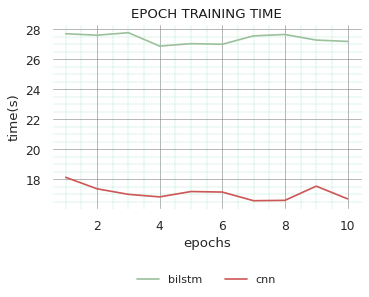

In [50]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history_bilstm.epoch_train_time, color=PALETTES.christmas[0], label='bilstm')
plt.plot(epochs, history_cnn.epoch_train_time, color=PALETTES.christmas[9], label='cnn')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next, we will **visualize the training loss** using a line graph.  

This plot shows how the loss evolved during training, helping us assess model convergence and detect potential overfitting.


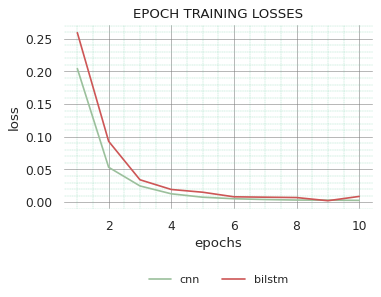

In [51]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history_cnn.train_losses, color=PALETTES.christmas[0], label='cnn')
plt.plot(epochs, history_bilstm.train_losses, color=PALETTES.christmas[9], label='bilstm')
plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()


Next, we will **visualize the validation loss** using a line graph.


This plot shows how the loss evolved during training, helping us assess model convergence and detect potential overfitting.

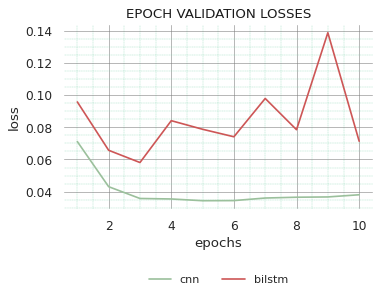

In [52]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history_cnn.val_losses, color=PALETTES.christmas[0], label='cnn')
plt.plot(epochs, history_bilstm.val_losses, color=PALETTES.christmas[9], label='bilstm')
plt.title("EPOCH VALIDATION LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next, we will **visualize the training and validation accuracies** using a line graph.  
This plot shows how the model's accuracy evolved during training, allowing us to evaluate performance and monitor potential overfitting.


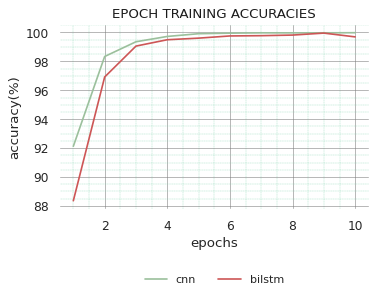

In [53]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history_cnn.train_acc], color=PALETTES.christmas[0], label='cnn')
plt.plot(epochs, [acc * 100 for acc in history_bilstm.train_acc], color=PALETTES.christmas[9], label='bilstm')

plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

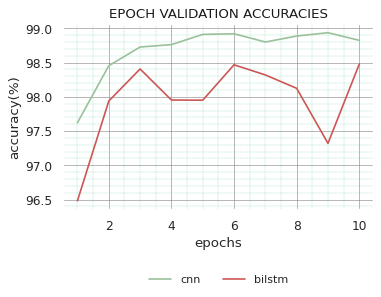

In [54]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history_cnn.val_acc], color=PALETTES.christmas[0], label='cnn')
plt.plot(epochs, [acc * 100 for acc in history_bilstm.val_acc], color=PALETTES.christmas[9], label='bilstm')

plt.title("EPOCH VALIDATION ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### 🏆 Best Model Evaluations

In the following code cell, we will **evaluate the best saved model** for each architecture.  
This allows us to assess the performance of the top-performing model on the validation or test data.


In [55]:
phishing_bilstm.load_state_dict(torch.load('bilstm.pt'))
phishing_cnn.load_state_dict(torch.load('cnn.pt'))

bilstm_test_loss, bistm_test_acc = evaluate_fn(phishing_bilstm, test_loader, criterions['bilstm'])
cnn_test_loss, cnn_test_acc = evaluate_fn(phishing_cnn, test_loader, criterions['cnn'])
rows = [
    ["CNN", f"{cnn_test_loss:.3f}", f"{cnn_test_acc*100:.2f}%"],
    ["BiLSTM", f"{bilstm_test_loss:.3f}", f"{bistm_test_acc*100:.2f}%"]
]
tabulate_data(["MODEL", "TEST LOSS", "TEST ACCURACY"], rows, "BEST MODEL EVALUATION")

BEST MODEL EVALUATION
+--------+-----------+---------------+
| MODEL  | TEST LOSS | TEST ACCURACY |
+--------+-----------+---------------+
| CNN    |     0.034 |        98.91% |
| BiLSTM |     0.058 |        98.41% |
+--------+-----------+---------------+


Next, we will **make predictions on the test dataset** using our trained models.  
This step allows us to see how well the model generalizes to unseen data.


In [56]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.sigmoid(y_pred).round().long()
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions

bilstm_y_true, bilstm_y_preds = get_predictions(phishing_bilstm, test_loader, device)
cnn_y_true, cnn_y_preds = get_predictions(phishing_cnn, test_loader, device)

### 🧮 Confusion Matrix

In the following code cell, we will **plot the confusion matrix** for our models.  


This visualization helps us understand how well the model predicts each phishing label and where misclassifications occur.


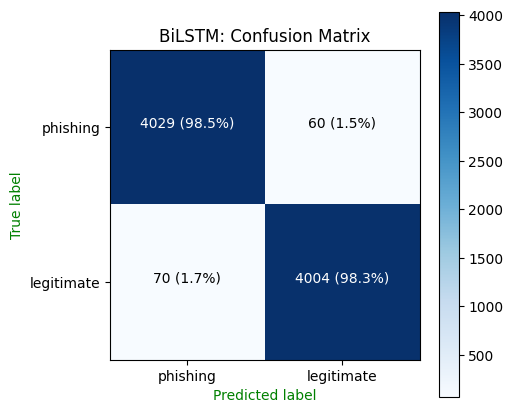

In [57]:
plt.style.use('default')
plot_complicated_confusion_matrix(bilstm_y_true, bilstm_y_preds,
  labels_dict.keys(), fontsize=10, figsize=(5, 5), title="BiLSTM: Confusion Matrix"
)

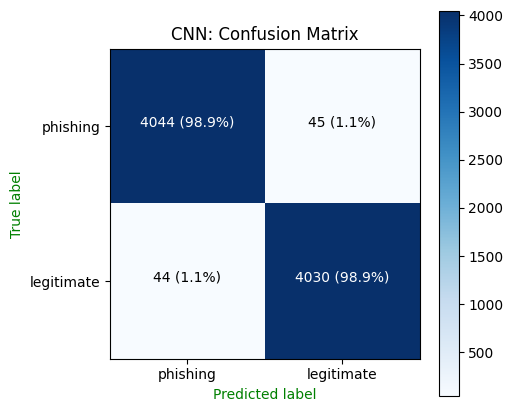

In [58]:
plot_complicated_confusion_matrix(cnn_y_true, cnn_y_preds,
  labels_dict.keys(), fontsize=10, figsize=(5, 5), title="CNN: Confusion Matrix"
)

### 📋 Classification Report

Next, we will **generate and display the classification report** for our model using the test dataset.  
This report provides metrics such as **precision, recall, F1-score, and support** for each class.


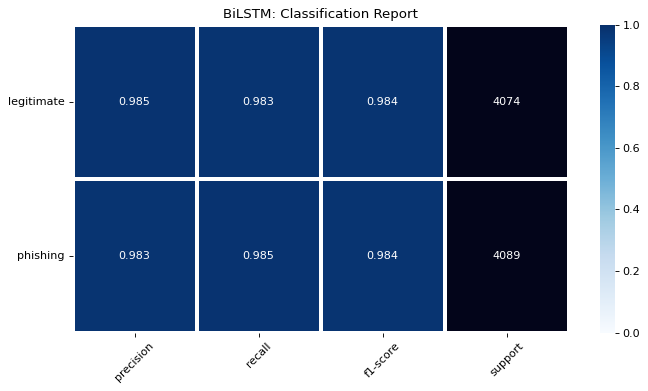

In [59]:
fig, ax = plot_classification_report(
    bilstm_y_true, bilstm_y_preds,
    title='BiLSTM: Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
)

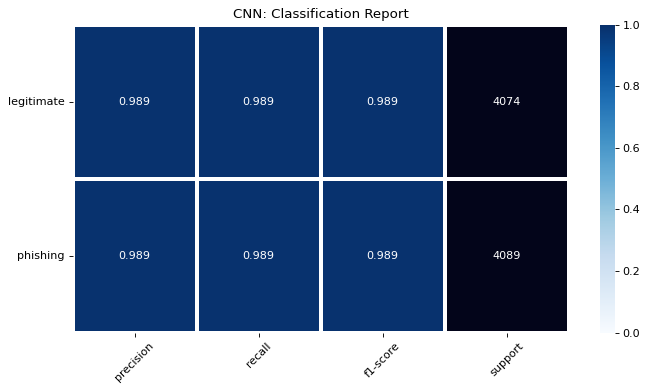

In [60]:
fig, ax = plot_classification_report(
    cnn_y_true, cnn_y_preds,
    title='CNN: Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
)

### 🤖 Model Inference

In this section, we will **test our model's ability to make predictions** based on user input.  

In the following code cell, we will use the **best model** to generate predictions.  
We will define a function called `inference_preprocess_text`, which **preprocesses the input text** to prepare it for inference.


In [61]:
def inference_preprocess_text(text, max_len=300, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [62]:
classes = list(labels_dict.keys())
def predict_phishing(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      length = torch.tensor([len(t) for t in tensor])
      prob = torch.sigmoid(model(tensor, length).squeeze(0)).cpu().item()
      prediction = 1 if prob >= 0.5 else 0
      class_name = classes[prediction]
      confidence = prob if prediction == 1 else 1 - prob
      pred_data = [
          ["class_id",  prediction],
          ["class_name",  class_name],
          ["probability",  round(float(confidence), 3)],
      ]
      return dict(pred_data)

### 📝 Prediction Example

In the following code cell, we will **predict a sample input**.


In [63]:
test.head(2)

,body,label
0,dear computer user your internet usage is bein...,phishing
1,sciencenow week in review all free articles to...,legitimate


In [64]:
test.iloc[1].body

'sciencenow week in review all free articles top last month scienceshots daily news archive about sciencenow all these sciencenow stories and more are available at www sciencenow org monday february navigating uncertain seasnew study says researchers lack data to determine whether global warming is redirecting ocean currents i hear you my monkey brothera region of the monkey brain responds preferentially to the voices of other monkeys unsubscribe or edit your subscriptions for this service at written requests to unsubscribe may be sent to customer service page mill road palo alto ca u s a magazine news signaling careers multimedia collections help site map rss subscribe feedback privacy legal about us advertise with us contact us american association for the advancement of science all rights reserved aaas is a partner of hinari agora patientinform crossref and counter'

### `Phishing`

In [65]:
phishing_txt = "dear computer user your internet usage is being tracked you have no privacy protection will your boss wife or kids find out download ez internet privacy software you're in serious trouble it's a proven fact deleting internet cache and history will not protect you because any of the web pages pictures movies videos sounds e mail chat logs and everything else you see or do could easily be recovered to haunt you forever how would you feel if a snoop made this information public to your spouse mother father neighbors children boss or the media it could easily ruin your life solve all your problems and enjoy all the benefits of an as new pc ez internet privacy software can speed up your pc internet browser reclaim hard disk space and professionally clean your pc in one easy mouse click did you know for example that every click you make on windows start menu is logged and stored permanently on a hidden encrypted database within your own computer deleting internet cache and history will not protect you your pc is keeping frightening records of both your online and off line activity any of the web pages pictures movies videos sounds e mail and everything else you or anyone else have ever viewed could easily be recovered even many years later how would you feel if somebody snooped this information out of your computer and made it public do your children or their friends use your computers what have they downloaded and tried to delete act now and stop these files coming back from the dead to haunt you click here to be removed click here iys"

print("Using BiLTSM:\n")
predict_phishing(
    phishing_bilstm,
    phishing_txt,
    device=device
)

Using BiLTSM:



{'class_id': 0, 'class_name': 'phishing', 'probability': 0.999}

In [66]:
print("Using CNN:\n")
predict_phishing(
    phishing_cnn,
    phishing_txt,
    device=device
)

Using CNN:



{'class_id': 0, 'class_name': 'phishing', 'probability': 1.0}

### `Legitimate`

In [67]:
legitimate_txt = "sciencenow week in review all free articles top last month scienceshots daily news archive about sciencenow all these sciencenow stories and more are available at www sciencenow org monday february navigating uncertain seasnew study says researchers lack data to determine whether global warming is redirecting ocean currents i hear you my monkey brothera region of the monkey brain responds preferentially to the voices of other monkeys unsubscribe or edit your subscriptions for this service at written requests to unsubscribe may be sent to customer service page mill road palo alto ca u s a magazine news signaling careers multimedia collections help site map rss subscribe feedback privacy legal about us advertise with us contact us american association for the advancement of science all rights reserved aaas is a partner of hinari agora patientinform crossref and counter"

print("Using BiLTSM:\n")
predict_phishing(
    phishing_bilstm,
    legitimate_txt,
    device=device
)

Using BiLTSM:



{'class_id': 1, 'class_name': 'legitimate', 'probability': 0.996}

In [68]:
print("Using CNN:\n")

predict_phishing(
    phishing_cnn,
    legitimate_txt,
    device=device
)

Using CNN:



{'class_id': 1, 'class_name': 'legitimate', 'probability': 1.0}